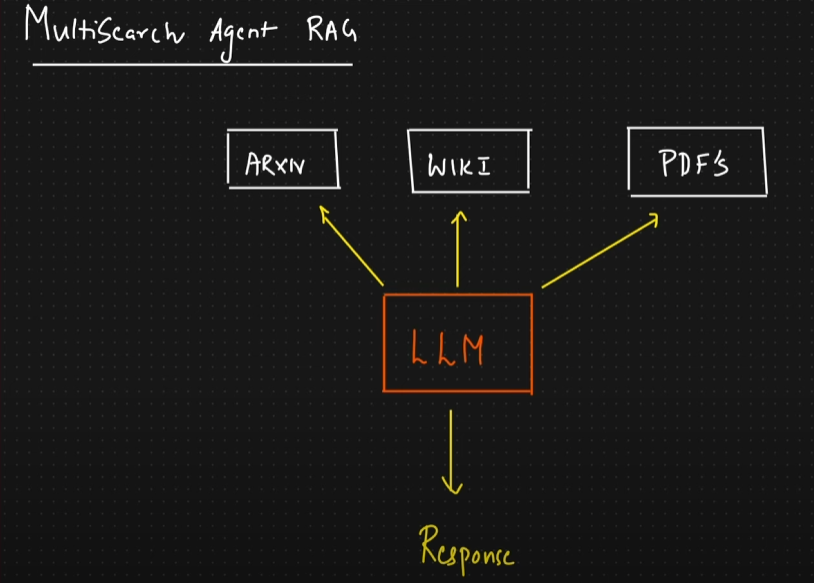

In [ ]:
# Install the ARXIV package

%pip install ARXIV

## Wikipedia

In [2]:
# Create a wrapper for Wikipedia

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

WikiWrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)

# Create a Wikipedia query run tool

WikiTool = WikipediaQueryRun(api_wrapper = WikiWrapper)


## Webpage

In [3]:
# Create a webpage loader

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


Webpage = WebBaseLoader(web_path = "https://docs.smith.langchain.com/")     
Document = Webpage.load()


# Create a text splitter to split the webpage content into smaller chunks

TextSplitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
Chunks = TextSplitter.split_documents(Document)

# Create a vector store to store the chunks

Embeddings = OllamaEmbeddings(model="llama3.2:3b")

vector_store = FAISS.from_documents(Chunks, Embeddings)

# Assign the retriever to the vector store to enable efficient retrieval of relevant chunks

retriever = vector_store.as_retriever()
print("Retriever:", retriever)


USER_AGENT environment variable not set, consider setting it to identify your requests.
C:\Users\admin\AppData\Local\Temp\ipykernel_45176\1528498094.py:20: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  Embeddings = OllamaEmbeddings(model="llama3.2:3b")


Retriever: tags=['FAISS', 'OllamaEmbeddings'] vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000028F5DECB620> search_kwargs={}


In [4]:
# Create a retriever tool

from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,"langsmith_search",
    "Search for information about LangSmith. For any questions about LangSmith, you must use this tool!")



## ARXIV

In [5]:
# Create a ARXIV tool

from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun

ArxivWrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
ArxivTool = ArxivQueryRun(api_wrapper = ArxivWrapper)

In [6]:
# Combine the retriever tool, Wikipedia Tool and the ARXIV tool into a single list of tools

Tools = [retriever_tool, WikiTool, ArxivTool]

Tools

[Tool(name='langsmith_search', description='Search for information about LangSmith. For any questions about LangSmith, you must use this tool!', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x0000028F5DFF9E40>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000028F5DECB620>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x0000028FA664D120>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000028F5DECB620>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, p

## LLM

In [7]:
from langchain_community.chat_models import ChatOllama

# Initialize the LLM with Ollama

LLM = ChatOllama(model="llama3.2:3b")

C:\Users\admin\AppData\Local\Temp\ipykernel_45176\1952483017.py:5: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  LLM = ChatOllama(model="llama3.2:3b")


In [8]:
# Create a prompt template for the agent from hub

from langchain import hub

prompt = hub.pull("hwchase17/openai-functions-agent")
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

## Agents

In [9]:
# Create an agent with the tools

from langchain.agents import create_openai_tools_agent

Agent = create_openai_tools_agent(llm=LLM, tools=Tools, prompt=prompt)

In [10]:
# Create an agent executor to run the agent with the tools

from langchain.agents import AgentExecutor

Executer = AgentExecutor(
    agent=Agent,
    tools=Tools,
    verbose=True
)

print("Agent Executor:", Executer)

Agent Executor: verbose=True agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Ta

In [12]:
# Execute the agent

Result = Executer.invoke({"input": "Tell me about Machine Learning?"})

print("Result:", Result)



> Entering new AgentExecutor chain...
Machine Learning (ML) is a subset of Artificial Intelligence (AI) that enables systems to automatically improve their performance on a task without being explicitly programmed. The goal of ML is to create algorithms that can learn from data, identify patterns, and make predictions or decisions based on that learning.

Here's a breakdown of the key concepts:

**Types of Machine Learning:**

1. **Supervised Learning**: The algorithm learns from labeled data (e.g., images with labels) and tries to replicate those labels.
2. **Unsupervised Learning**: The algorithm discovers patterns and relationships in unlabeled data (e.g., clustering, dimensionality reduction).
3. **Reinforcement Learning**: The algorithm learns by interacting with an environment and receiving rewards or penalties for its actions.

**Machine Learning Process:**

1. **Data Collection**: Gathering relevant data for the task.
2. **Data Preprocessing**: Cleaning, transforming, and for